# Intro of this file
+ Heads: segmentation + binary + bbox
+ Performs 5 fold cv on (main args might want to change: batchsize=8, fold=5, ep=10)
+ To change the fold numbers, simply change "CVfolds" in the section "Start cross validation"
+ loader and train is modified compared to the main branch


In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import backend as K
import numpy as np
import random
import matplotlib.pyplot as plt

from utils.loader import DataLoader
from models.effnet_encoder import EffnetEncoder
from models.mtl_framework import MTLFramework
from utils import tools, config

In [2]:
# Set configs
batch_size = 8
batch_size_val = 8
num_train, num_val, num_test = config.config['num_train'], config.config['num_val'], config.config['num_test']
img_height, img_width, channels = config.config['input_shape']

### Build our MTL

In [3]:
def build_model(img_height, img_width, channels):
    ### CLEARS OLD MODELS IN CACHE
    tf.keras.backend.clear_session()

    # Get encoder
    base_model_name = 'B0'
    encoder = EffnetEncoder(base_model_name, (img_height, img_width, channels)).build_encoder(trainable=True)

    # Use our MTL framework to custom build a model
    mtl_builder = MTLFramework(encoder, (img_height, img_width, channels))
    mtl_builder.add_segmentation_head()
    mtl_builder.add_binary_classification_head(base_model_name, trainable=True)
    mtl_builder.add_bbox_classification_head(base_model_name, trainable=True)
    model = mtl_builder.build_mtl_model()

    return model

### Train model

In [4]:
def generator_img(img_ds, masks_ds, label_ds, bbox_ds):
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds.as_numpy_iterator()
    b = masks_ds.as_numpy_iterator()
    c = label_ds.as_numpy_iterator()
    d = bbox_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        Y3 = d.next()
        
        # Regularisation and shuffling
        X, Y1, Y2, Y3 = tools.get_randomised_data([X, Y1, Y2, Y3])
        # X, Y1, Y3 = tools.data_augmentation(X, Y1, Y3) # Fix augmentation
        
        yield X, (Y1, Y2, Y3)

In [5]:
def generator_img_val(img_ds_val, masks_ds_val, label_ds_val, bbox_ds):
    ''' Merges together datasets into a unified generator to pass for training '''
    a = img_ds_val.as_numpy_iterator()
    b = masks_ds_val.as_numpy_iterator()
    c = label_ds_val.as_numpy_iterator()
    d = bbox_ds.as_numpy_iterator()
    
    while True:
        X = a.next()
        Y1 = b.next()
        Y2 = c.next()
        Y3 = d.next()
        
        yield X, (Y1, Y2, Y3)

### Start cross validation

In [6]:
##### Change this to modify the folds #####
CVfolds = 5
ep = 10
###########################################
cv_history = []
num_train_cv = num_train * (CVfolds-1)/CVfolds
num_val_cv = num_train * 1/CVfolds

for cv_iter in range(CVfolds):
      # CrossVal: 0 = no CV, 1 = training set, 2 = val set
      loader1 = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val, CrossVal=1, CV_iteration=cv_iter, fold=CVfolds)
      loader2 = DataLoader(batch_size=batch_size, batch_size_val=batch_size_val, CrossVal=2, CV_iteration=cv_iter, fold=CVfolds)

      # Train set
      img_ds = loader1.get_image_ds().repeat()
      masks_ds = loader1.get_mask_ds().repeat()
      label_ds = loader1.get_binary_ds().repeat()
      bbox_ds = loader1.get_bboxes_ds().repeat()

      # Validation set
      img_ds_val = loader2.get_image_ds().repeat()
      masks_ds_val = loader2.get_mask_ds().repeat()
      label_ds_val = loader2.get_binary_ds().repeat()
      bbox_ds_val = loader2.get_bboxes_ds().repeat()
      
      model = build_model(img_height, img_width, channels)

      model.compile(optimizer=keras.optimizers.Adam(1e-4),
                  loss={'segnet_out' : tf.keras.losses.BinaryCrossentropy(from_logits=True),
                        'bin_class_out' : tf.keras.losses.BinaryCrossentropy(),
                        'bbox_out' : tf.keras.losses.MeanAbsoluteError()},
                  loss_weights=[1,1,1/100], # Scale MAE to BC range
                  metrics=['accuracy'])

      print(f"-------------------- start cross val {cv_iter+1}/{CVfolds} --------------------")

      history = model.fit(generator_img(img_ds, masks_ds, label_ds, bbox_ds), 
                        validation_data=generator_img_val(img_ds_val, masks_ds_val, label_ds_val, bbox_ds), 
                        epochs=ep, 
                        steps_per_epoch=num_train_cv//batch_size, 
                        validation_steps=num_val_cv//batch_size_val)

      # save the final val_acc of each cv step
      cv_history.append(history.history)
                       


-------------------- start cross val 1/5 --------------------
Epoch 1/10
221/221 [==============================] - 87s 348ms/step - loss: 1.7614 - segnet_out_loss: 0.4349 - bin_class_out_loss: 0.2195 - bbox_out_loss: 110.7047 - segnet_out_accuracy: 0.7961 - bin_class_out_accuracy: 0.9219 - bbox_out_accuracy: 0.2981 - val_loss: 1.3945 - val_segnet_out_loss: 0.2448 - val_bin_class_out_loss: 0.0283 - val_bbox_out_loss: 112.1396 - val_segnet_out_accuracy: 0.9177 - val_bin_class_out_accuracy: 0.9955 - val_bbox_out_accuracy: 0.3932
Epoch 2/10
221/221 [==============================] - 76s 346ms/step - loss: 1.3544 - segnet_out_loss: 0.2230 - bin_class_out_loss: 0.0464 - bbox_out_loss: 108.5103 - segnet_out_accuracy: 0.9212 - bin_class_out_accuracy: 0.9870 - bbox_out_accuracy: 0.4361 - val_loss: 1.2671 - val_segnet_out_loss: 0.1749 - val_bin_class_out_loss: 0.0385 - val_bbox_out_loss: 105.3655 - val_segnet_out_accuracy: 0.9386 - val_bin_class_out_accuracy: 0.9886 - val_bbox_out_accuracy: 0.4

In [7]:
# extract the wanted metrics
result = []
for i in range(CVfolds):
    result.append([cv_history[i]['segnet_out_accuracy'],
                    cv_history[i]['val_segnet_out_accuracy']])

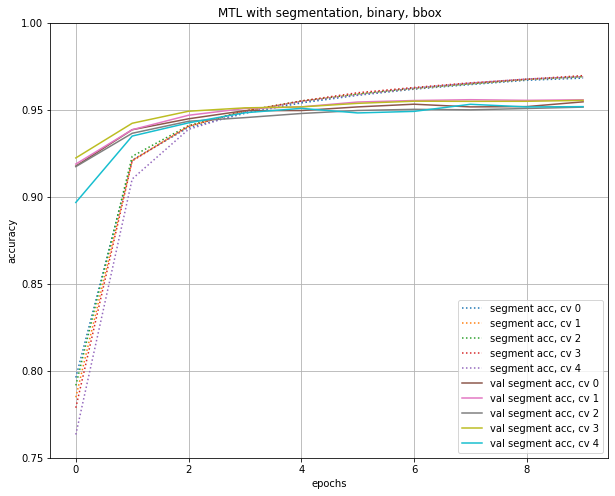

In [8]:
fig, ax = plt.subplots(figsize=(10, 8))
for i in range(CVfolds):
    ax.plot(result[i][0], linestyle=":", label = f"segment acc, cv {i}")
for i in range(CVfolds):
    ax.plot(result[i][1], linestyle="-", label = f"val segment acc, cv {i}")
ax.set_xlabel('epochs')
ax.set_ylabel('accuracy')
ax.set_title('MTL with segmentation, binary, bbox')
plt.legend()
plt.ylim([0.75, 1])
plt.grid()
plt.show()

In [9]:
# Print out the results to see offline
print("set \tsegmen ")
for i in range(CVfolds):
    print(f"CV {i+1} \t{np.round(result[i][1][-1], 4)}")

print("-----------------------------")
avg = np.round(np.mean(result, axis=0), 4)
std = np.round(np.std(result, axis=0), 4)
print(f"Avg  \t{avg[1][-1]} ")
print(f"Std  \t{std[1][-1]} ")


set 	segmen 
CV 1 	0.9546
CV 2 	0.9558
CV 3 	0.9516
CV 4 	0.9555
CV 5 	0.9519
-----------------------------
Avg  	0.9539 
Std  	0.0018 
